In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List
from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs
mpl.rcParams['figure.dpi'] = 300

MAXCUT- Classical

In [3]:
for key in graphs.keys():
    print(key)

barbell_unweighted
barbell_float(-1_1)
barbell_int(-5_5)
circular_small_unweighted
circular_small_float(-1_1)
circular_small_int(-5_5)
circular_large_unweighted
circular_large_float(-1_1)
circular_large_int(-5_5)
fully_connected_small_unweighted
fully_connected_small_float(-1_1)
fully_connected_small_int(-5_5)
fully_connected_large_unweighted
fully_connected_large_float(-1_1)
fully_connected_large_int(-5_5)


In [4]:
graph = nx.Graph()
#Add nodes and edges
graph.add_nodes_from(np.arange(0,6,1))
edges = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),(1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
graph.add_weighted_edges_from(edges)
graphs['custom'] = graph
#Display widget
display_maxcut_widget(graphs['custom'])

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

Output()

In [5]:
def maxcut_cost_fn(graph: nx.Graph, bitstring: List[int]) -> float:
    """
    Computes the maxcut cost function value for a given graph and cut represented by some bitstring
    Args:
        graph: The graph to compute cut values for
        bitstring: A list of integer values '0' or '1' specifying a cut of the graph
    Returns:
        The value of the cut
    """
    #Get the weight matrix of the graph
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0
    #INSERT YOUR CODE TO COMPUTE THE CUT VALUE HERE
    for i in range(size):
        for j in range(size):
            value = value + weight_matrix[i,j]*bitstring[i]*(1-bitstring[j])
    return value

def plot_maxcut_histogram(graph: nx.Graph) -> None:
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    Args:
        graph: The graph to compute cut values for
    """
    num_vars = graph.number_of_nodes()
    #Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_cost_fn(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    #Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings)))
    #Plot bar diagram
    bar_plot = go.Bar(x = bitstrings, y = values, marker=dict(color=values, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
    fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1500, height = 600))
    fig.show()

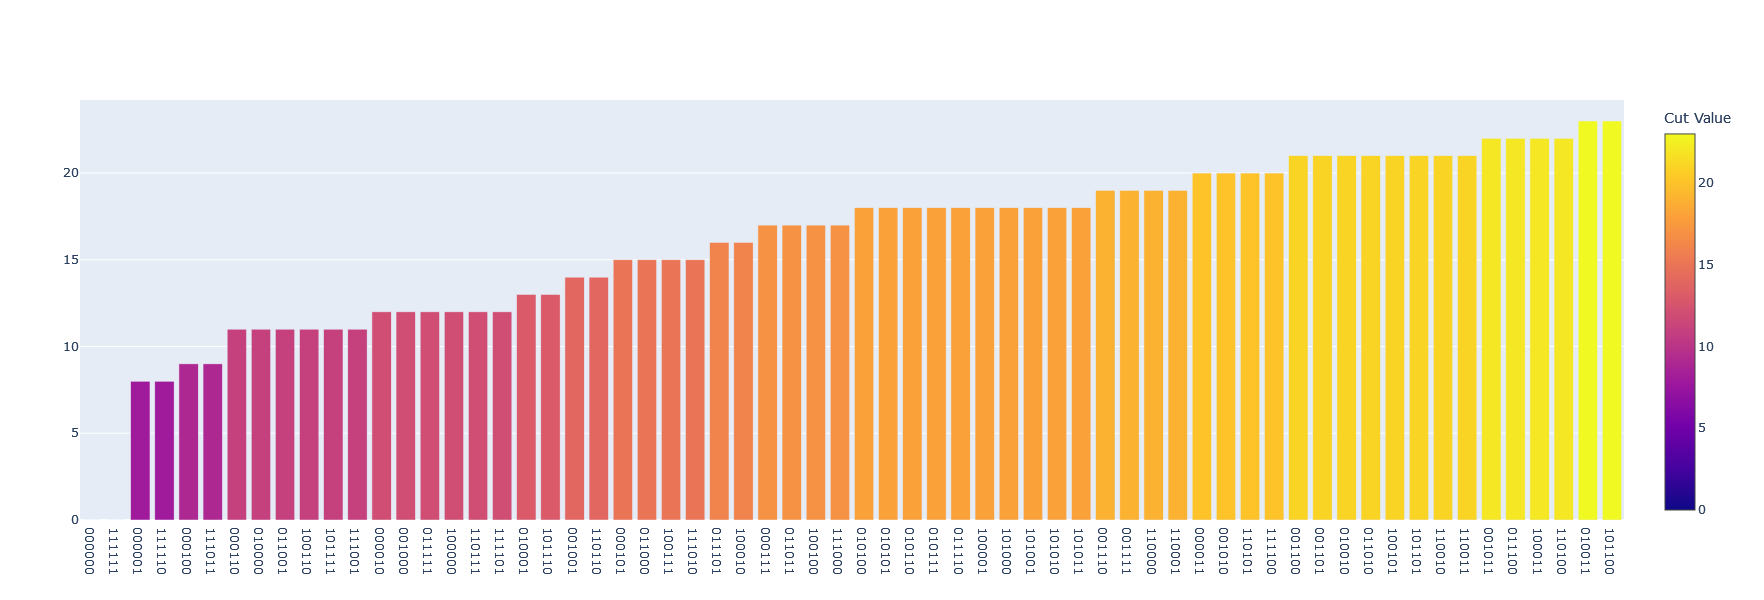

In [30]:
plot_maxcut_histogram(graph = graphs['custom'])

MAXCUT as a Quadratic Programme

In [7]:
from qiskit_optimization import QuadraticProgram
quadratic_program = QuadraticProgram('sample_problem')
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: sample_problem

Minimize
 obj:
Subject To

Bounds
End



In [8]:
quadratic_program.binary_var(name = 'x_0')
quadratic_program.integer_var(name = 'x_1')
quadratic_program.continuous_var(name = 'x_2', lowerbound = -2.5, upperbound = 1.8)

In [9]:
quadratic = [[0,1,2],[3,4,5],[0,1,2]]
linear = [10,20,30]
quadratic_program.minimize(quadratic = quadratic, linear = linear, constant = -5)
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: sample_problem

Minimize
 obj: 10 x_0 + 20 x_1 + 30 x_2 + [ 8 x_0*x_1 + 4 x_0*x_2 + 8 x_1^2 + 12 x_1*x_2
      + 4 x_2^2 ]/2 -5
Subject To

Bounds
 0 <= x_0 <= 1
 -2.500000000000 <= x_2 <= 1.800000000000

Binaries
 x_0

Generals
 x_1
End



### MaxCut as a Quadratic Program and the MAXCUT QUBO Formulation
We can formulate any MaxCut problem as a quadratic program. Consider again the cost function for a MaxCut problem with symmetric weight matrix $W$
$$
C(x) = \sum_{i,j=1}^n W_{ij} x_i (1-x_j).
$$
This is clearly a quadratic cost function and we can reformulate it in the standard form for quadratic programs as written above.
$$
\begin{align}
\sum_{i,j=1}^n W_{ij} x_i (1-x_j) &= \sum_{i,j=1}^n W_{ij} x_i - W_{ij}x_i x_j  \\
&= \sum_{i=1}^n \left( \sum_{j=1}^n W_{ij} \right) x_i - \sum_{i,j = 1}^n W_{ij}x_i x_j \\
&= c^T x + x^T Q x, \\
\end{align}
$$
for $Q$ and $c$ defined as follows
$$
Q_{ij} = -W_{ij} \qquad c_i = \sum_{j=1}^n W_{ij}.
$$
Thus, we obtain an optimization instance with binary variables, a quadratic objective function and without any variable constraints. A quadratic program of that form is also called a quadratic unconstrained binary optimization instance, or QUBO for short.

In [10]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]

    #INSERT YOUR CODE HERE
    quadratic_program = QuadraticProgram('sample_problem')
    for i in range(size):
        quadratic_program.binary_var(name = 'x_{}'.format(i))
    quadratic_program.maximize(quadratic = qubo_matrix, linear = qubo_vector)
        #quadratic_program = np.transpose(qubo_vector[i])*x + np.transpose(x)*qubo_matrix[i, j]*x
        #quadratic_program.binary_var(x)
    return quadratic_program

In [11]:
quadratic_program = quadratic_program_from_graph(graphs['custom'])
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: sample_problem

Maximize
 obj: 12 x_0 + 11 x_1 + 12 x_2 + 9 x_3 + 12 x_4 + 8 x_5 + [ - 8 x_0*x_1
      - 12 x_0*x_2 - 8 x_0*x_3 - 16 x_0*x_4 - 4 x_0*x_5 - 16 x_1*x_2 - 4 x_1*x_3
      - 4 x_1*x_4 - 12 x_1*x_5 - 8 x_2*x_4 - 12 x_2*x_5 - 20 x_3*x_4 - 4 x_3*x_5
      ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



QAOA (Quantum approximate optimization algorithm)

In [12]:
def qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    #Outer loop to create each layer
    for i in range(p):

        #Apply R_Z rotational gates from cost layer
        #INSERT YOUR CODE HERE
        for j in range(size):
            qubo_matrix_sum_of_col = 0
            for k in range(size):
                qubo_matrix_sum_of_col += qubo_matrix[j][k]

            qaoa_circuit.rz(gammas[i]*(qubo_linearity[j]+qubo_matrix_sum_of_col),j)
    #for irep in range(0, p):
        #Apply R_ZZ rotational gates for entangled qubit rotations from cost layer
        #INSERT YOUR CODE HERE
        for j in range(size):
            for k in range(size):
                if j != k:
                    qaoa_circuit.rzz(gammas[i]*qubo_matrix[j][k]*0.5,j,k)
        
        # Apply single qubit X - rotations with angle 2*beta_i to all qubits
        #INSERT YOUR CODE HERE
        for j in range(size):
            qaoa_circuit.rx(2 * betas[i], j)
        

    return qaoa_circuit

In [14]:
from qiskit.circuit import Parameter, ParameterVector
quadratic_program = quadratic_program_from_graph(graphs['custom'])
custom_circuit = qaoa_circuit(qubo = quadratic_program)

In [16]:
custom_circuit

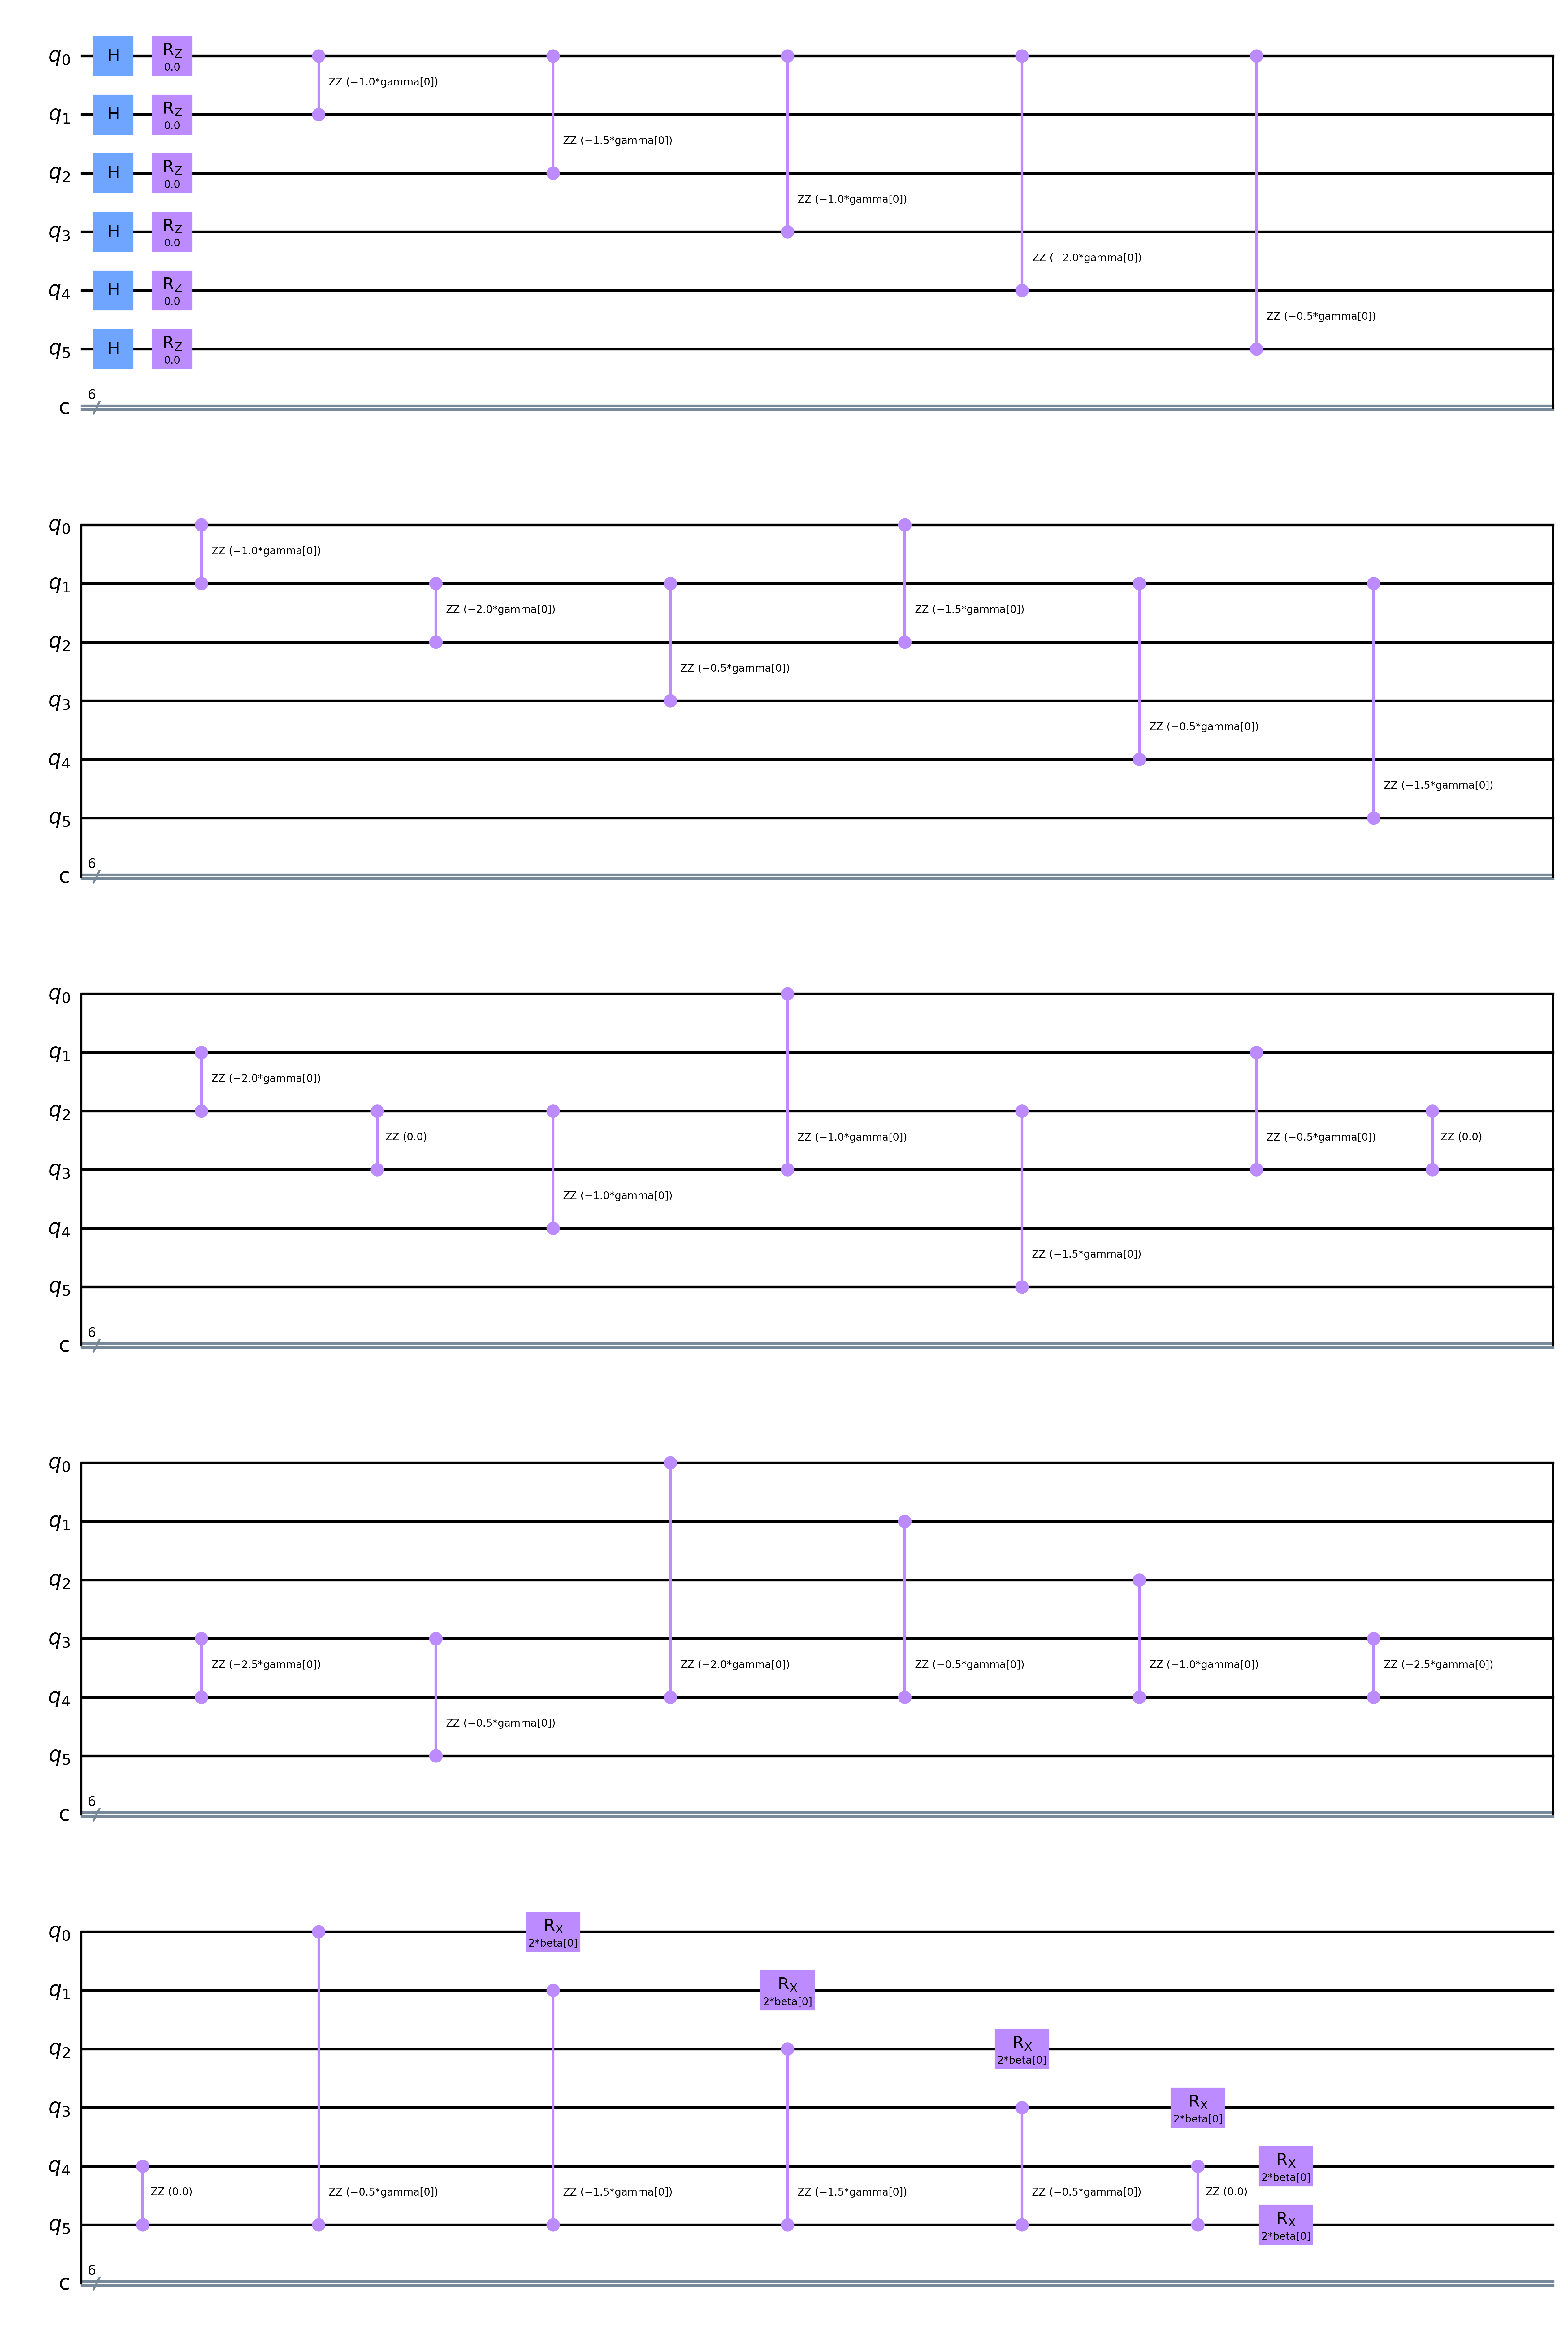

In [17]:
custom_circuit.draw('mpl')

The QAOA and MinimumEigenOptimizer class

In [15]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
backend = Aer.get_backend('statevector_simulator')
qaoa = QAOA(optimizer = ADAM(), quantum_instance = backend, reps=1, initial_point = [0.1,0.1])
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
quadratic_program = quadratic_program_from_graph(graphs['custom'])
result = eigen_optimizer.solve(quadratic_program)
print(result)

optimal function value: 23.0
optimal value: [1. 0. 1. 1. 0. 0.]
status: SUCCESS


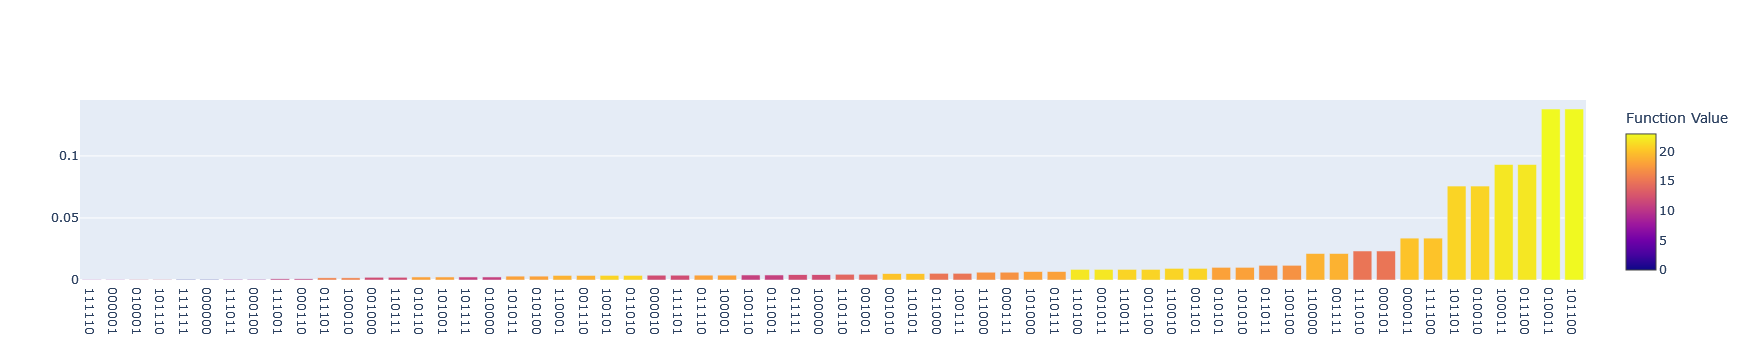

In [27]:
def plot_samples(samples):
    """
    Plots a bar diagram for the samples of a quantum algorithm
    Args:
        samples
    """
    #Sort samples by probability
    samples = sorted(samples, key = lambda x: x.probability)
    #Get list of probabilities, function values and bitstrings
    probabilities = [sample.probability for sample in samples]
    values = [sample.fval for sample in samples]
    bitstrings = [''.join([str(int(i)) for i in sample.x]) for sample in samples]
    #Plot bar diagram
    sample_plot = go.Bar(x = bitstrings, y = probabilities, marker=dict(color=values, colorscale = 'plasma',colorbar=dict(title='Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.show()

plot_samples(result.samples)

The VQE and MinimumEigenOptimizer class

In [26]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver
#backend = Aer.get_backend('statevector_simulator')
#qaoa = QAOA(optimizer = ADAM(), quantum_instance = backend, reps=1, initial_point = [0.1,0.1])
#eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
quadratic_program = quadratic_program_from_graph(graphs['custom'])
#result = eigen_optimizer.solve(quadratic_program)
#print(result)
from qiskit import BasicAer
algorithm_globals.random_seed = 10598
quantum_instance = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)
vqe_circ = VQE(quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_circ)
vqe_result = vqe.solve(quadratic_program)
print(vqe_result)

optimal function value: 23.0
optimal value: [0. 1. 0. 0. 1. 1.]
status: SUCCESS


### Higher values of $p$

With higher values of $p$, QAOA is theoretically able to reach a quantum state with a better energy value with respect to the cost Hamiltonian since increasing the number of layers strictly increases the space of quantum states, one is able to reach. That is, if 
$$
M_p = \max_{\beta, \gamma \in \mathbb{R}^p} \langle \psi_p(\beta, \gamma) \vert H_C  \vert \psi_p(\beta, \gamma) \rangle
$$
denotes the maximal energy value reachable with a QAOA variational form of depth $p$, it holds that
$$
M_{p+1} \geq M_p.
$$
In fact, using the adiabatic theorem, one can prove, that in the infinite limit, we are able to reach the maximal cost function value $C_{max}$
$$
\lim\limits_{p \to \inf} M_p = C_{max}.
$$
While the connection to adiabatic quantum computing serves as a justification of why we might expect QAOA to yield good optimization results, it only holds in the infinite limit, which in turn corresponds to an infinitely long quantum algorithm.
One also needs to be mindful of the fact that the number of parameters increases with the number of layers, and finding the global optimum becomes increasingly harder when introducing more parameters.<br>
The following plots show the evolution of the optimal QAOA state found for increasing values of $p$ and give some idea of how the circuit depth affects QAOA performance.

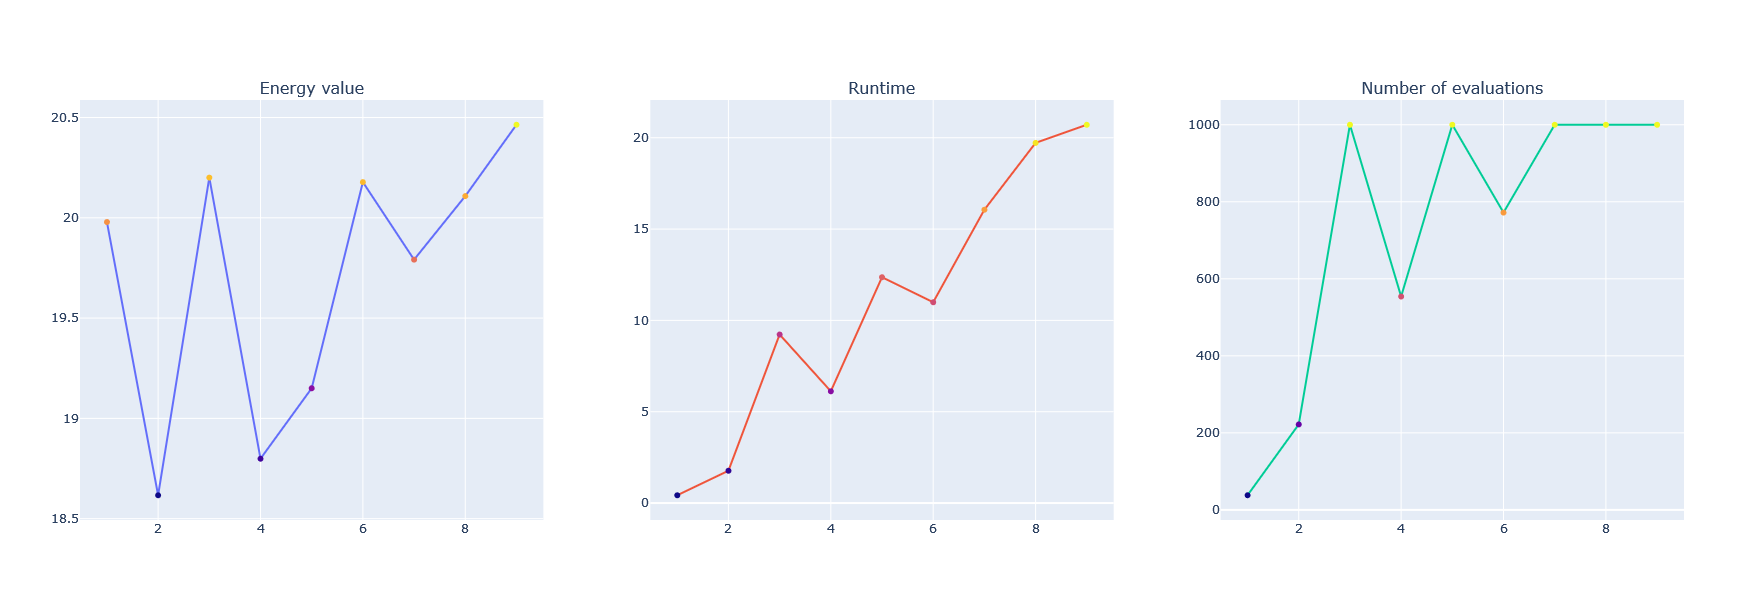

In [20]:
graph_name = 'custom'
quadratic_program = quadratic_program_from_graph(graphs[graph_name])
#Create callback to record total number of evaluations
max_evals = 0
def callback(eval_count, params, mean, std_dev):
    global max_evals
    max_evals = eval_count

#Create empty lists to track values
energies = []
runtimes = []
num_evals=[]
    
#Run QAOA for different values of p
for p in range(1,10):
    print(f'Evaluating for p = {p}...')
    qaoa = QAOA(optimizer = optimizers['cobyla'], quantum_instance = backend, reps=p, callback=callback)
    eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
    start = time()
    result = eigen_optimizer.solve(quadratic_program)
    runtimes.append(time()-start)
    num_evals.append(max_evals)
    #Calculate energy of final state from samples
    avg_value = 0.
    for sample in result.samples:
        avg_value += sample.probability*sample.fval
    energies.append(avg_value)

#Create and display plots
energy_plot = go.Scatter(x = list(range(1,10)), y =energies, marker=dict(color=energies, colorscale = 'plasma'))
runtime_plot = go.Scatter(x = list(range(1,10)), y =runtimes, marker=dict(color=runtimes, colorscale = 'plasma'))
num_evals_plot = go.Scatter(x = list(range(1,10)), y =num_evals, marker=dict(color=num_evals, colorscale = 'plasma'))
fig = make_subplots(rows = 1, cols = 3, subplot_titles = ['Energy value', 'Runtime', 'Number of evaluations'])
fig.update_layout(width=1800,height=600, showlegend=False)
fig.add_trace(energy_plot, row=1, col=1)
fig.add_trace(runtime_plot, row=1, col=2)
fig.add_trace(num_evals_plot, row=1, col=3)
clear_output()
fig.show()

### CVaR
One recently proposed adaptation to QAOA is the idea of calculating the Conditional Value at Risk (or CVaR). Here, instead of calculating the mean of all cut values $c_i$ obtained from the measurement outcomes of the circuit to compute the cost function $f$, the algorithm only takes into account a fraction $\alpha$ of the highest measured cut values.
$$
f(\theta) = \frac{1}{n}\sum_{i=1}^n c_i \to f(\theta) = \frac{1}{\lceil \alpha n \rceil}\sum_{i=1}^{\lceil \alpha n \rceil} c_i,
$$
where the $c_i$ are ordered decreasing in size.
Since we are only interested in obtaining a single good solution for the original optimization problem, looking only at a fraction of the best cuts can help to speed up the optimization process. Let us explore how adding CVaR can change the energy landscape of a QAOA instance. The following code creates and plots a QAOA energy landscape of a given MaxCut instance and returns the optimal parameters obtained during a grid search. Calculating the energy landscape might take a while.

In [21]:
def plot_qaoa_energy_landscape(graph: nx.Graph, cvar: float = None):
    num_shots = 1000
    seed = 42
    simulator = Aer.get_backend('qasm_simulator')
    simulator.set_options(seed_simulator = 42)

    #Generate circuit
    circuit = qaoa_circuit(qubo = quadratic_program_from_graph(graph), p=1)
    circuit.measure(range(graph.number_of_nodes()),range(graph.number_of_nodes()))

    #Create dictionary with precomputed cut values for all bitstrings 
    cut_values = {}
    size = graph.number_of_nodes()
    for i in range(2**size):
        bitstr = '{:b}'.format(i).rjust(size, '0')[::-1]
        x = [int(bit) for bit in bitstr]
        cut_values[bitstr] = maxcut_cost_fn(graph, x)

    #Perform grid search over all parameters
    data_points = []
    max_energy = None
    for beta in np.linspace(0,np.pi, 50):
        for gamma in np.linspace(0, 4*np.pi, 50):
            bound_circuit = circuit.assign_parameters([beta, gamma])
            result = simulator.run(bound_circuit, shots = num_shots).result()
            statevector = result.get_counts(bound_circuit)
            energy = 0
            measured_cuts = []
            for bitstring, count in statevector.items():
                measured_cuts =  measured_cuts + [cut_values[bitstring]]*count

            if cvar is None:
                #Calculate the mean of all cut values
                energy = sum(measured_cuts)/num_shots
            else:
                #raise NotImplementedError()
                #INSERT YOUR CODE HERE
                measured_cuts = sorted(measured_cuts, reverse=True)
                energy = 0 
                for i in range(int(cvar*num_shots)):
                    energy+=measured_cuts[i]
                energy = energy / int(cvar*num_shots)
            #Update optimal parameters
            if max_energy is None or energy > max_energy:
                max_energy = energy
                optimum = {'beta': beta, 'gamma': gamma, 'energy': energy}

            #Update data
            data_points.append({'beta': beta, 'gamma': gamma, 'energy': energy})


    #Create and display surface plot from data_points
    df = pd.DataFrame(data_points)
    df = df.pivot(index='beta', columns='gamma', values='energy')
    matrix = df.to_numpy()
    beta_values = df.index.tolist()
    gamma_values = df.columns.tolist()

    surface_plot = go.Surface(
        x=gamma_values, 
        y=beta_values,
        z=matrix,
        coloraxis = 'coloraxis'
    )
    fig = go.Figure(data = surface_plot)
    fig.show()

    #Return optimum
    return optimum


In [22]:
graph = graphs['custom']
optimal_parameters = plot_qaoa_energy_landscape(graph = graph)
print('Optimal parameters:')
print(optimal_parameters)

Optimal parameters:
{'beta': 0.32057067893773394, 'gamma': 6.411413578754679, 'energy': 19.392}


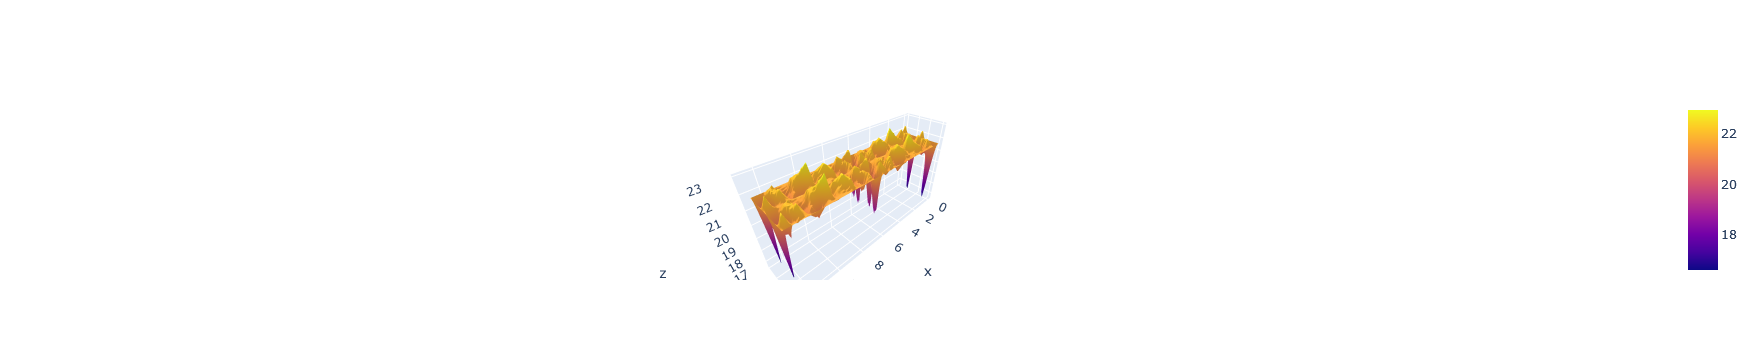

{'beta': 0.7052554936630148, 'gamma': 2.821021974652059, 'energy': 22.925}


In [23]:
optimal_parameters = plot_qaoa_energy_landscape(graph = graph, cvar = 0.2)
print(optimal_parameters)